In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
train_df = pd.read_csv("train.csv", index_col=0)
test_df = pd.read_csv("test.csv", index_col=0)
data_sets = [train_df, test_df]

In [3]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
len(train_df.dtypes[train_df.dtypes == 'object']), len(train_df.dtypes[train_df.dtypes != 'object'])

(43, 37)

First glipmse at the features. Quite a lof of them - 43 categorical and 38 numerical.

In [5]:
train_is_null = train_df.isnull().sum()/len(train_df)
cols_wnulls = train_is_null[train_is_null>0.3]
fetures_wnulls = cols_wnulls.index.values
train_df[fetures_wnulls].isnull().sum()/len(train_df)

Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

There are few features in training df with very high content of null values which we will not be able to recover any usefull information from, therefore the only option is to delete them.

In [6]:
test_w_nulls = test_df.isnull().sum()/len(test_df) >0.3
test_df.isnull().sum()[test_w_nulls]/len(test_df)

Alley          0.926662
FireplaceQu    0.500343
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64

Train and test datasets are in agreemnent when high content of nulls is concerned.

In [7]:
cols_high_null = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
for data in data_sets:
    data.drop(columns=cols_high_null, inplace=True)
train_df, test_df = data_sets

In [8]:
isnull_train = train_df.isnull().sum()>0
isnull_test = test_df.isnull().sum()>0
train_df.isnull().sum()[isnull_train], test_df.isnull().sum()[isnull_test]

(LotFrontage     259
 MasVnrType        8
 MasVnrArea        8
 BsmtQual         37
 BsmtCond         37
 BsmtExposure     38
 BsmtFinType1     37
 BsmtFinType2     38
 Electrical        1
 GarageType       81
 GarageYrBlt      81
 GarageFinish     81
 GarageQual       81
 GarageCond       81
 dtype: int64, MSZoning          4
 LotFrontage     227
 Utilities         2
 Exterior1st       1
 Exterior2nd       1
 MasVnrType       16
 MasVnrArea       15
 BsmtQual         44
 BsmtCond         45
 BsmtExposure     44
 BsmtFinType1     42
 BsmtFinSF1        1
 BsmtFinType2     42
 BsmtFinSF2        1
 BsmtUnfSF         1
 TotalBsmtSF       1
 BsmtFullBath      2
 BsmtHalfBath      2
 KitchenQual       1
 Functional        2
 GarageType       76
 GarageYrBlt      78
 GarageFinish     78
 GarageCars        1
 GarageArea        1
 GarageQual       78
 GarageCond       78
 SaleType          1
 dtype: int64)

There is a quite some columns with only few nulls in it. I will use 'backfill' method to fill all of them, since it is the less time consuming and should provide some gain.

In [9]:
for data in data_sets:
    data.fillna(method='backfill', inplace=True)
train_df, test_df = data_sets

In [10]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

#### Since our data is clean now, it is time to start visualization part!

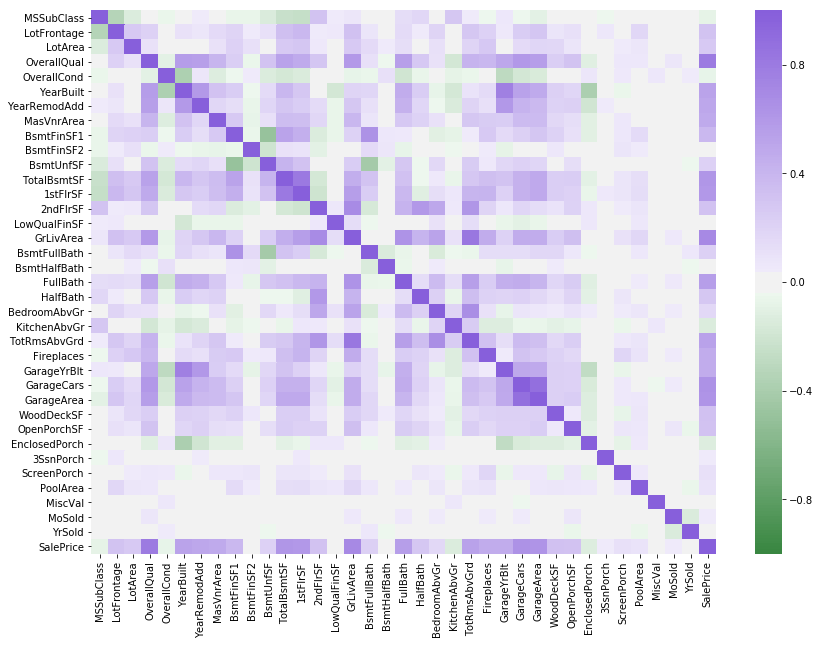

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(train_df.corr(), cmap= sns.diverging_palette(130, 275, n=200), vmin=-1, vmax=1);

One can see that there are quite some features correlated with Sale Price. The strongest seems to be OverallQual.
Few features are also correlated within each other like YearBuilt and GarageYrBlt which seem to reasonable or GarageCars and GarageArea.

In [12]:
feats_max_corr = train_df.corr().nlargest(20, columns='SalePrice')['SalePrice'].index.values.tolist()
train_df.corr().nlargest(20, columns='SalePrice')['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472645
Fireplaces      0.466929
GarageYrBlt     0.463384
BsmtFinSF1      0.386420
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
LotFrontage     0.302758
HalfBath        0.284108
Name: SalePrice, dtype: float64

GarageCars and GarageArea are corelated with each other pretty strongly so one can be explained by the other - we can exclude one from analysis. Same with Yearbuilt ang GarageYearBuilt.

In [13]:
feats_max_corr.remove('GarageArea')
feats_max_corr.remove('GarageYrBlt')

Let's visualize the dependent variable - SalePrice and look for features affecting it.

In [14]:
train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

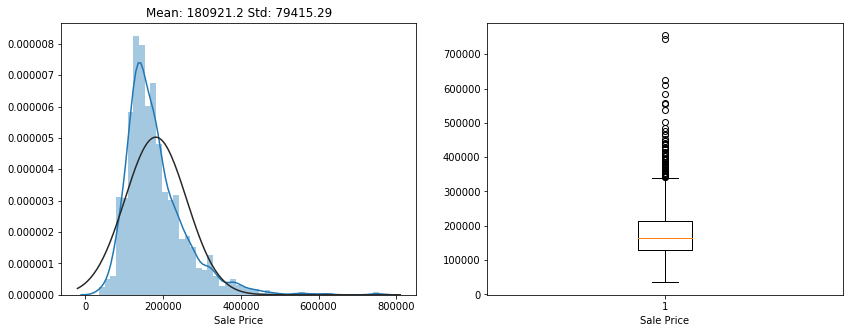

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Mean: {} Std: {}".format(round(np.mean(train_df.SalePrice),2),
                                    round(np.std(train_df.SalePrice),2)))
sns.distplot(train_df['SalePrice'], fit=norm, axlabel='Sale Price');
plt.subplot(1,2,2)
plt.boxplot(train_df.SalePrice);
plt.xlabel('Sale Price');
# sns.boxplot(train_df.SalePrice, orient='v');

Okay, the distribution is not normal but it is not very skewed or with high peaks. Should we convert it to be more normal? Depends how it will improve model performance.
What is important if the residuals are normally distributed if so then we can explain our dependent variable with the features we have if not there is some other relation that we don't undesrtand yet and the predicitons are biased. (Model is able to capture all explanatory information)
Looking at the boxplot above one can see that there might be several candidates for outliers in range above 500k. 

In [16]:
print("Skewness: {}, Kurtosis: {}".format(train_df.SalePrice.skew(), train_df.SalePrice.kurtosis()))

Skewness: 1.8828757597682129, Kurtosis: 6.536281860064529


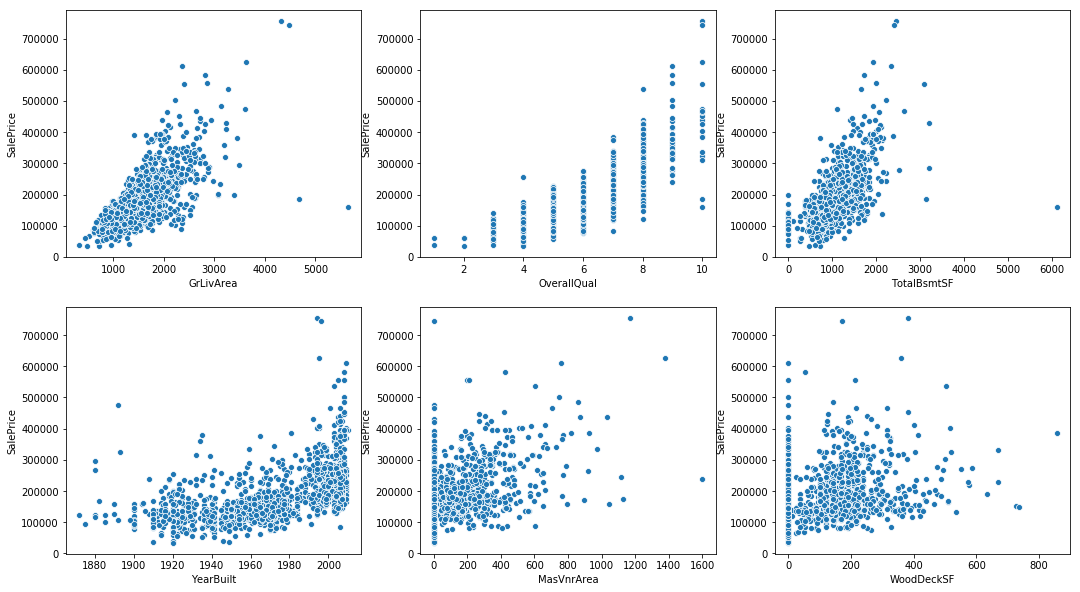

In [17]:
plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df);
plt.subplot(2,3,2)
sns.scatterplot(x='OverallQual', y='SalePrice', data=train_df);
plt.subplot(2,3,3)
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train_df);
plt.subplot(2,3,4)
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_df);
plt.subplot(2,3,5)
sns.scatterplot(x='MasVnrArea', y='SalePrice', data=train_df);
plt.subplot(2,3,6)
sns.scatterplot(x='WoodDeckSF', y='SalePrice', data=train_df);

SalePrice vs GrLivArea and SalePrice vs TotalBsmtSF indicate a potential outliers on high SalePrice values and on high TotalBsmtSF/GrLivArea values

Analyzing MasVnrArea or WoodDeckSF or TotalBsmtSF one can see a vertical line at value 0, that suggest that additional binary feature worth introducing would be whether this hause is equipped with this feature or not. (MasVnrArea is actually covered in MasVnrType)

In [18]:
has_dict = {'TotalBsmtSF':'Has_Bsmt', 'WoodDeckSF': 'Has_Wood', 'PoolArea': 'Has_Pool'}
for key, value in has_dict.items():
    for data in data_sets:
        data[value] = data[key].apply(lambda x: True if x > 0 else False)
train_df, test_df = data_sets

8 highest correlated features on pairplot

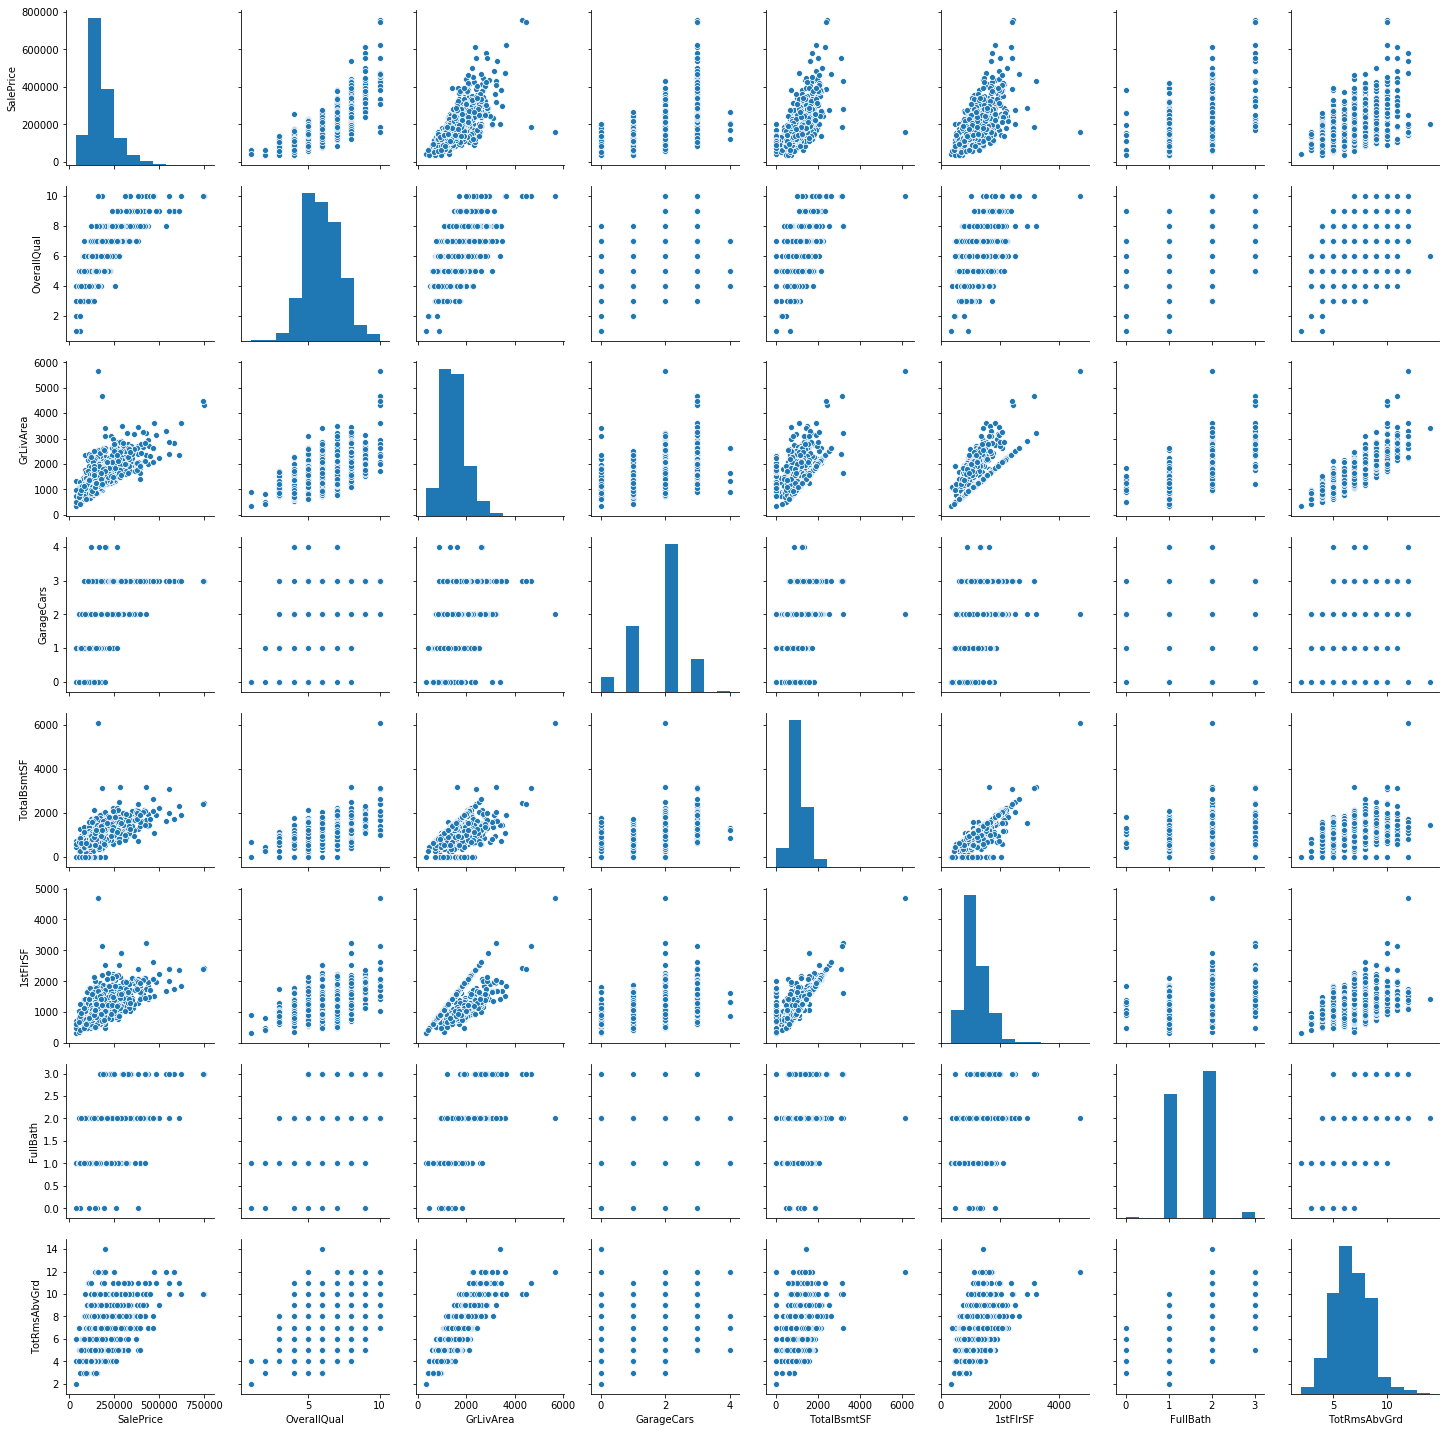

In [19]:
sns.pairplot(train_df[feats_max_corr[0:8]]);

#### Building a predictive model

In [20]:
test_df.shape, train_df.shape

((1459, 77), (1460, 78))

In [21]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Has_Bsmt,Has_Wood,Has_Pool
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,120,0,0,6,2010,WD,Normal,True,True,False
1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,12500,6,2010,WD,Normal,True,True,False
1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,3,2010,WD,Normal,True,True,False
1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,6,2010,WD,Normal,True,True,False
1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,144,0,0,1,2010,WD,Normal,True,False,False


In [22]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
X_train, X_val, Y_train, Y_val = train_test_split(train_df.drop(columns='SalePrice'), train_df.SalePrice, 
                                                  random_state=42, test_size=0.3)

In [23]:
def make_predictions(model):
    model.fit(X_train, Y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    return y_pred_train, y_pred_val

In [24]:
y_pred_train, y_pred_val = make_predictions(LinearRegression())

In [25]:
r2_score(Y_train, y_pred_train), mean_squared_error(Y_train, y_pred_train)

(0.9329431557215143, 403586677.93005407)

In [26]:
r2_score(Y_val, y_pred_val), mean_squared_error(Y_val, y_pred_val)

(0.8888435587266457, 775660069.3378104)

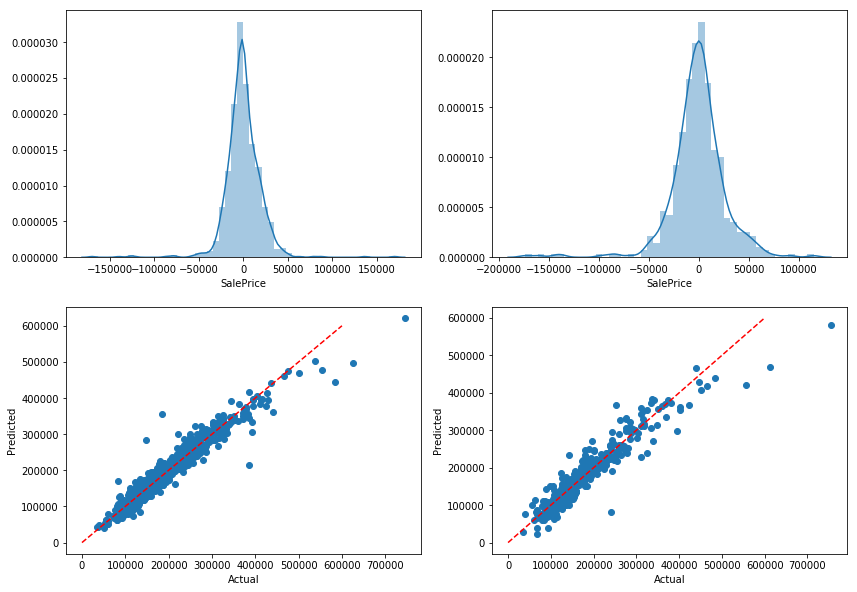

In [27]:
def plot_residuals(y_pred_train, Y_train, y_pred_val, Y_val):    
    training_res = y_pred_train - Y_train
    test_res = y_pred_val - Y_val
    plt.figure(figsize=(14,10))
    plt.subplot(2,2,1);
    sns.distplot(training_res);
    plt.subplot(2,2,2);
    sns.distplot(test_res);
    plt.subplot(2,2,3);
    plt.scatter(Y_train, y_pred_train);
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.plot([0, 600000], [0, 600000], color='r', linestyle='dashed');
    plt.subplot(2,2,4);
    plt.scatter(Y_val, y_pred_val);
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.plot([0, 600000], [0, 600000], color='r', linestyle='dashed');
    
plot_residuals(y_pred_train, Y_train, y_pred_val, Y_val)

The error distribution of residuals on training data set looks normal, but there is a couple of points which shows sigificant error - reaching 200000. Error distribution is a little bit skewed which means the model cannot explain few points, it can also be seen on predicted vs actual plot. This can also be the problem of a few outliers that has been noted in data visualization part.

In [28]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
models[0].__class__.__name__

'LinearRegression'

In [29]:
summary_df = pd.DataFrame(columns=['r2_score_train', 'mse_train', 'r2_score_val', 'mse_val'])
summary_df

,r2_score_train,mse_train,r2_score_val,mse_val


In [30]:
for model in models:
    y_pred_train, y_pred_val = make_predictions(model)
    summary_df.loc[model.__class__.__name__, :] = [r2_score(Y_train, y_pred_train), mean_squared_error(Y_train, y_pred_train), r2_score(Y_val, y_pred_val), mean_squared_error(Y_val, y_pred_val)]
summary_df

[22:12:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,r2_score_train,mse_train,r2_score_val,mse_val
LinearRegression,0.932943,4.03587e+08,0.888844,7.7566e+08
DecisionTreeRegressor,1,0,0.792859,1.44545e+09
RandomForestRegressor,0.970626,1.76788e+08,0.873415,8.83319e+08
XGBRegressor,0.967576,1.95144e+08,0.895022,7.32545e+08


In [31]:
model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>

Interesting results. DecisionTreeRegressor has overfit so badly that it claims r2_score of 1 and 0 error! It is common for simple Decision Trees to overfit, on validation data set is shows the worst result out of all models. 
The best results can be seen for XGboost, lowest error on training and slightly lower erorr and higher R2 than Linear Regression.

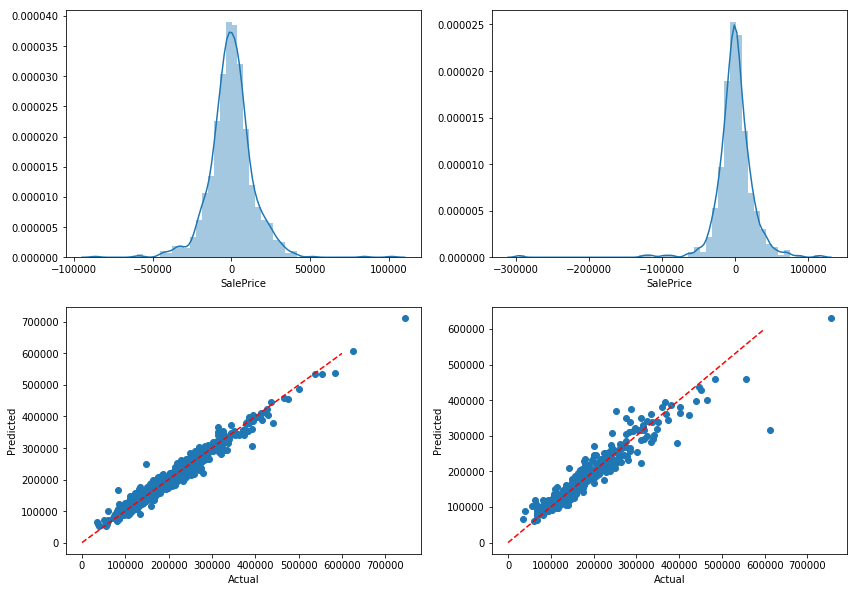

In [32]:
plot_residuals(y_pred_train, Y_train, y_pred_val, Y_val)

Plotting 15 most important features determined by XGboost.

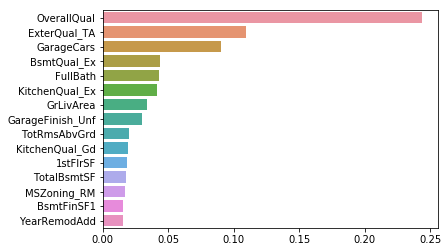

In [33]:
feats_imp = pd.Series(index=X_train.columns, data=model.feature_importances_)
feats_15 = feats_imp.sort_values(ascending=False).head(15)
sns.barplot(feats_15.values, feats_15.index.values);

Considering only those 15 most important features from now on.

In [34]:
important_feats = feats_15.index.values.tolist()
train_df = train_df[important_feats + ['SalePrice']]
test_df = test_df[important_feats]
X_train, X_val, Y_train, Y_val = train_test_split(train_df.drop(columns='SalePrice'), train_df.SalePrice, 
                                                  random_state=42, test_size=0.3)

The feature with most significance seem to be OverallQual - which is a rate of overall material and finish of the house. It is a numerical feature with scale from 1-10 and it made sense to keep it like that because with increase of 1 there is associated increase in value of house.
Second feature - ExterQual binary TA - says about external material quality being in average condition, feature was changed to binary by pandas get_dummies but it may actually make sense to assign a scale 1-n to it.
Next features like GarageCars and FullBath - is reasonable to have then impacting Sale Price of house.

#### Model tunning in CV
Now it is time to tune the best model - XGboost and see how much we can improve by just adjusting the model hyperparameters.
Since the process is computationally expensive, it will be broken up into two pieces.

In [47]:
params1 = {'n_estimators' : [50, 100, 200], 'max_depth': [3,4,5], 'random_state':[0]}
params2 = {'random_state':[0], 'learning_rate': [0.05, 0.1, 0.2, 0.3], 'min_child_weight': [1,3,6],
           'gamma' : [0, 0.1, 0.2, 0.5]}
xgb = XGBRegressor(objective ='reg:squarederror')
regr = GridSearchCV(xgb, params1, cv=3)
regr.fit(X_train, Y_train)
regr.best_params_

{'max_depth': 3, 'n_estimators': 100, 'random_state': 0}

In [48]:
xgb = XGBRegressor(objective ='reg:squarederror')
regr = GridSearchCV(xgb, params2, cv=3)
regr.fit(X_train, Y_train)
regr.best_params_

{'gamma': 0, 'learning_rate': 0.1, 'min_child_weight': 1, 'random_state': 0}

In [52]:
xgb_regr = XGBRegressor(max_depth = 3, n_estimators = 100, random_state = 0, gamma = 0,
                        learning_rate = 0.1, min_child_weight = 1)
xgb_regr.fit(X_train, Y_train)
y_pred_val = xgb_regr.predict(X_val)
r2_score(Y_val, y_pred_val), mean_squared_error(Y_val, y_pred_val)

[22:16:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.9080582173426668, 641578379.9307749)

Hyperparameters tunning allowed for small improvement in r2 score and decrease of mse on validation data set used previously with several models.

#### Now it's time to train on a full training data set, make a prediction on test and submit results!

In [51]:
xgb_regr.fit(train_df.drop(columns='SalePrice'), train_df.SalePrice)
Y_pred = xgb_regr.predict(test_df)
test_df['SalePrice'] = Y_pred
submission_df = test_df[['SalePrice']]

ValueError: feature_names mismatch: ['OverallQual', 'ExterQual_TA', 'GarageCars', 'BsmtQual_Ex', 'FullBath', 'KitchenQual_Ex', 'GrLivArea', 'GarageFinish_Unf', 'TotRmsAbvGrd', 'KitchenQual_Gd', '1stFlrSF', 'TotalBsmtSF', 'MSZoning_RM', 'BsmtFinSF1', 'YearRemodAdd'] ['OverallQual', 'ExterQual_TA', 'GarageCars', 'BsmtQual_Ex', 'FullBath', 'KitchenQual_Ex', 'GrLivArea', 'GarageFinish_Unf', 'TotRmsAbvGrd', 'KitchenQual_Gd', '1stFlrSF', 'TotalBsmtSF', 'MSZoning_RM', 'BsmtFinSF1', 'YearRemodAdd', 'SalePrice']
training data did not have the following fields: SalePrice

In [40]:
submission_df.head()

,SalePrice
Id,
1461,123432.875000
1462,154441.281250
1463,164653.078125
1464,182922.875000
1465,202864.250000


In [41]:
submission_df.to_csv('houses_submission.csv')